In [ ]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import string

%config InlineBackend.figure_format='retina'

characters=string.digits+string.ascii_uppercase#验证码的元素含有数字和大写字母
print(characters)#0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ
len(characters)#36
width,height,n_len,n_class=170,80,4,len(characters)#验证码宽高长度和元素类别数
generator=ImageCaptcha(width=width,height=height)#生成空白验证码图片对象
random_str=''.join([random.choice(characters) for j in  range(4)])#随机生成4个元素，用空字符串链接
img=generator.generate_image(random_str)#验证码图片对象上生成元素
plt.imshow(img)
#img=np.array(img)
#cv2.imwrite(r'D:\DeepLearning\captcha.jpg',img)
plt.title(random_str)


In [ ]:
#为了让 Keras 能够使用多进程并行生成数据，我们需要使用 Keras 的 Sequence 类实现一个我们自己的数据类。
from keras.utils import Sequence
class CaptchaSequence(Sequence):
    def __init__(self,characters,batch_size,steps,n_len=4,width=170,height=80):
        self.characters=characters
        self.batch_size=batch_size
        self.steps=steps
        self.n_len=n_len
        self.width=width
        self.height=height
        self.n_class=len(characters)
        self.generator=ImageCaptcha(width=width,height=height)#验证码图片对象
    def __len__(self):
        return self.steps
    def __getitem__(self,idx):
        x=np.zeros((self.batch_size,self.height,self.width,3),dtype=np.float32)
        #初始化图片数据全是0，按固定输入维度
        y=[np.zeros((self.batch_size, self.n_class), dtype=np.uint8) for i in range(self.n_len)]
        #初始化4个输出[4个输出层，batch_size,n_classes]
        for i in range(self.batch_size):#在一个batch中循环生成batch_size个数据
            random_str=''.join([random.choice(self.characters) for j in range(self.n_len)])#随机生成每个captcha的4个元素
            x[i]=np.array(self.generator.generate_image(random_str))/255.0#对象生成验证码

            for j,ch in enumerate(random_str):
                y[j][i,:]=0#在一个batch中的第i个图片中，第j个输出的所有类别（36）输出都是0
                y[j][i,self.characters.find(ch)]=1#第j个输出的第ch维输出是1
        #print((np.array(x)).shape)
        return x,y

#实例化数据生成器，并且解码输出
def decode(y):
    y=np.argmax(np.array(y),axis=2)[:,0]
    return ''.join([characters[x] for x in y])
data=CaptchaSequence(characters,batch_size=1,steps=1)
x,y=data[0]

plt.imshow(x[0])
plt.title(decode(y))


In [ ]:
#卷积网络
from keras.models import *
from keras.layers import *
input_tensor=Input((height,width,3))
x=input_tensor
print(x.shape)
for i,n_cnn in enumerate([2,2,2,2,2]):
    for j in range(n_cnn):
        x=Conv2D(32*2**min(i,3),kernel_size=3,padding='same',kernel_initializer='he_uniform')(x)
        x=BatchNormalization()(x)
        x=Activation('relu')(x)
    x=MaxPooling2D(2)(x)
    
x=Flatten()(x)
x=[Dense(n_class,activation='softmax',name='c%d'%(i+1))(x) for i in range(n_len)]
model=Model(inputs=input_tensor,outputs=x)

#模型可视化，pip install pydot ， graphviz ，pydot-ng
from keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='cnn.png', show_shapes=True)
Image('cnn.png')

#模型训练
from keras.callbacks import EarlyStopping,CSVLogger,ModelCheckpoint
from keras.optimizers import *
train_data=CaptchaSequence(characters,batch_size=128,steps=10)
valid_data=CaptchaSequence(characters,batch_size=128,steps=1)
callbacks=[EarlyStopping(patience=3),CSVLogger('cnn.csv'),ModelCheckpoint('cnn_best.h5',save_best_only=True)]
model.compile(loss='categorical_crossentropy',optimizer=Adam(1e-3,amsgrad=True),metrics=['accuracy'])
model.fit(train_data,epochs=10,validation_data=valid_data,callbacks=callbacks)


In [ ]:
#模型测试
x,y=data[0]
y_pred=model.predict(x)
plt.title('real:%s\npred:%s'%(decode(y),decode(y_pred)))
plt.imshow(x[0],cmap='gray')
plt.axis('off')


In [ ]:

import cv2

img=cv2.imread('sample/new_train/1_ehgz.png',cv2.IMREAD_GRAYSCALE)

erode_img=cv2.erode(img,kernel=np.ones((3,3),np.uint8),iterations=6)
dilate_img=cv2.dilate(img,kernel=np.ones((3,3),np.uint8),iterations=6)


preground_img=img-dilate_img
background_img=img-erode_img

cv2.imshow("preground_img",preground_img)
cv2.imshow("background_img",background_img)
cv2.imshow("img",img)
cv2.imshow("erode_img",erode_img)
cv2.imshow("dilate_img",dilate_img)


cv2.waitKey(0)
cv2.destroyAllWindows()

print(img.shape)




## 灰度化处理

In [ ]:
import cv2
import numpy as np

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    return binary

def remove_noise(binary):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # 创建一个3x3的矩形核
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=5)
    
    cleaned=cv2.erode(cleaned,kernel=np.ones((3,3),np.uint8),iterations=1)
    
    return cleaned

def separate_characters(cleaned):
    labels, num_labels = cv2.connectedComponents(cleaned)
    character_images = []

    # 只保留最大的几个连通组件
    max_num_components = 4  # 根据你的验证码长度设置
    for i in range(1, min(max_num_components, num_labels)):
        mask = np.zeros_like(labels, dtype="uint8")
        mask[np.where(labels == i)] = 255
        character_images.append(mask)

    return character_images

def display_results(character_images):
    for image in character_images:
        cv2.imshow("Character", image)
        cv2.waitKey(0)


def kmeans_segmentation(image, num_clusters):
    # 将图像转换为一维向量
    pixel_values = image.reshape(-1, 3).astype(np.float32)
    # 运行K-means算法
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1)
    _, labels, centers = cv2.kmeans(pixel_values, num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # 将每个像素分配到最近的聚类中心
    segmented_image = centers[labels.flatten()].reshape(image.shape)
    return segmented_image

image = cv2.imread("sample/new_train/1_ehgz.png")  # 请替换为你的验证码图片路径
image = cv2.resize(image,(600,200))

binary_image = preprocess_image(image)
cleaned_image = remove_noise(binary_image)

cv2.imshow("origin_image", image)
cv2.imshow("cleaned_image", cleaned_image)
cv2.waitKey(0)

## 绘制直方图

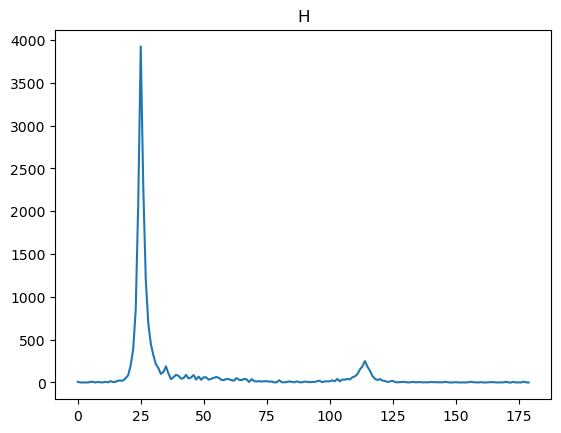

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

dir_path="sample/new_train"

for subDir in os.listdir(dir_path):
    for file in os.listdir(dir_path+'/'+subDir):
        
        image = cv2.imread(dir_path+'/'+subDir+'/'+file)  
        
        hsv=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
        hist=cv2.calcHist([hsv],[0],None,[180],[0,180])

        plt.plot(hist)
        plt.title('H')
        plt.show()

        cv2.imshow("image", image)
        cv2.waitKey(0)
        
        break
    break



## 区域生长

In [14]:
import cv2
import numpy as np
import os

def region_growing_rgb(image,segmented_image, seed_point, threshold=20):
    # 初始化
    height, width, _ = image.shape
    # segmented_image = np.zeros(image.shape, dtype=np.uint8)
    seed_queue = [seed_point]
    while seed_queue:
        x, y = seed_queue.pop(0)
        if segmented_image[x, y].any() != 0:  # 已经访问过
            continue
        segmented_image[x, y] = image[x, y]  # 标记当前像素为已访问

        for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:  # 邻域像素
            nx, ny = x + dx, y + dy
            if 0 <= nx < height and 0 <= ny < width and \
               np.sqrt((image[nx, ny , 0] - image[x, y , 0])**2) < threshold:

                seed_queue.append((nx, ny))
    # return segmented_image


def preprocess_image(image):
    # 将图像转换为灰度图
    # image = cv2.imread(image_path)
    kernel = np.ones((3, 3), np.uint8)
    grey=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # background_img=cv2.dilate(grey,kernel,iterations=50)

    # grey=grey-background_img

    # cv2.imshow('grey',grey)
    # cv2.waitKey(0)
    _,binary=cv2.threshold(grey,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)


    # binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel,iterations=1)
    # 进行形态学操作，去除噪声
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
    # 进行形态学操作，填充区域
    sure_bg = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel,iterations=1)
    # cv2.imwrite('processEffect/' + image_path[-10:],sure_bg)

    #寻找二值图像的轮廓
    # contours, hierarchy = cv2.findContours(sure_bg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.drawContours(sure_bg, contours, -1, (255, 255, 255), 1)
    grey=cv2.bitwise_and(grey,grey,mask=sure_bg)
    # image=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    # hist=cv2.calcHist([grey],[0],None,[180],[0,180])

    # plt.plot(hist)
    # plt.title('H')
    # plt.show()

    # cv2.imshow('image',grey)
    # cv2.waitKey(0)


    #裁剪
    ans=sure_bg[12:sure_bg.shape[0]-12,45:sure_bg.shape[1]-45]
    
    # cv2.imshow('ans',ans)
    # cv2.waitKey(0)
    return ans

    # 将sure_bg中的所有像素为255的坐标记录
    cordinates=np.argwhere(sure_bg==255)
    # print(cordinates)

    # processed_image=np.zeros_like(image)
    # 遍历坐标，将坐标点对应的像素值设为255
    # processed_image[cordinates[:,0],cordinates[:,1]]=image[cordinates[:,0],cordinates[:,1]]
    
    # cv2.imshow('processed_image',processed_image)
    # cv2.waitKey(0)

    threshold=10
    hsv=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    segmented_image=np.zeros_like(hsv)


    for seed in cordinates:
        region_growing_rgb(hsv,segmented_image, seed, threshold=threshold)
    
    # cv2.imshow('segmented_image',segmented_image)
    # 遍历坐标，将坐标点对应的像素值设为255

    processed_image=cv2.cvtColor(segmented_image,cv2.COLOR_HSV2BGR)
    
    return processed_image
    # segmented_image=np.zeros_like(image)


    # threshold=220
    # for seed in cordinates:
    #     region_growing_rgb(image,segmented_image, seed, threshold=threshold)

    # cv2.imshow('processed_image',processed_image)
    # cv2.imshow('segmented_image',segmented_image)
    # cv2.waitKey(0)
    # cv2.imwrite('processEffect/' + image_path[-10:],processed_image)

    # cv2.destroyAllWindows()



# dir_path="sample/new_train/"
# target_path="sample/train_processed"
# for subDir in os.listdir(dir_path):
#     for filename in os.listdir(dir_path + '/' + subDir):
#         file_path = dir_path + '/' + subDir + '/' + filename
#         image=cv2.imread(file_path)
#         processed=preprocess_image(image)


#         # pos=filename.rfind('.')
#         # cv2.putText(processed, filename[pos-4:pos], (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
#         # cv2.imshow('processed_image',processed)
#         # cv2.waitKey(0)
#         # cv2.destroyAllWindows()
#         # break
#         cv2.imwrite('processEffect/' + filename,processed)
dir_path="sample/new_train/predict"
target_path="sample/processedPredict/"

for filename in os.listdir(dir_path):
    file_path = dir_path + '/' + filename
    image=cv2.imread(file_path)
    processed=preprocess_image(image)
    cv2.imwrite(target_path  + filename,processed)



## Kmeans 聚类

In [ ]:
def kmeans_segmentation(image, num_clusters):
    # 将图像转换为一维向量
    pixel_values = image.reshape(-1, 3).astype(np.float32)
    # 运行K-means算法
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1)
    _, labels, centers = cv2.kmeans(pixel_values, num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # 将每个像素分配到最近的聚类中心
    segmented_image = centers[labels.flatten()].reshape(image.shape)
    return segmented_image


num_clusters = 2  # 设置聚类簇的数量

## 基于鼠标的区域生长

In [ ]:

seed_points=[]
def Mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(param, (x, y), 3, (0, 0, 255), -1)    # 画圆
        seed_points.append((y, x))


for filename in os.listdir(dir_path):
    file_path = dir_path + '/' + filename
    # print(file_path[-10:])
    image = cv2.imread(file_path)
    
    imageCopy=image.copy()

    cv2.namedWindow('image')
    cv2.setMouseCallback('image', Mouse_callback, param=imageCopy)
    

    while True:
        cv2.imshow('image', imageCopy)
        key = cv2.waitKey(1) & 0xFF
        if key == 27:
            break
    cv2.destroyAllWindows()
    
    segmented_image=np.zeros_like(image)
    threshold=300
    for seed in seed_points:
        region_growing_rgb(image,segmented_image, seed, threshold=threshold)

    cv2.imshow('segmented_image',segmented_image)
    cv2.waitKey(0)
    seed_points=[]
    

    break


## 分水岭算法

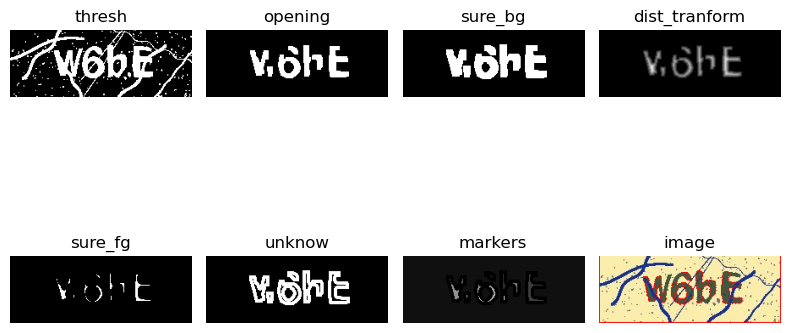

In [13]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os


def test_watershed(image_path) :
    image = cv.imread(image_path)
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    #基于直方图的二值化处理
    _, thresh = cv.threshold(image_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    #做开操作，是为了除去白噪声
    kernel = np.ones((3, 3), dtype = np.uint8)
    opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations = 2)

    #做膨胀操作，是为了让前景漫延到背景，让确定的背景出现
    sure_bg = cv.dilate(opening, kernel, iterations = 1)

    #为了求得确定的前景，也就是注水处使用距离的方法转化
    dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
    
    #归一化所求的距离转换，转化范围是[0, 1]
    cv.normalize(dist_transform, dist_transform, 0, 1.0, cv.NORM_MINMAX)
    #再次做二值化，得到确定的前景
    _, sure_fg = cv.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    #得到不确定区域也就是边界所在区域，用确定的背景图减去确定的前景图
    unknow = cv.subtract(sure_bg, sure_fg)

    #给确定的注水位置进行标上标签，背景图标为0，其他的区域由1开始按顺序进行标
    _, markers = cv.connectedComponents(sure_fg)

    # cv.imshow('markers', markers.astype(np.uint8))
    # cv.waitKey(0)

    #让标签加1，这是因为在分水岭算法中，会将标签为0的区域当作边界区域（不确定区域）
    markers += 1

    #是上面所求的不确定区域标上0
    markers[unknow == 255] = 0
    # print(markers.dtype)  int32
    markers_copy = markers.copy()

    # 使用分水岭算法执行基于标记的图像分割，将图像中的对象与背景分离
    markers = cv.watershed(image, markers)

    #分水岭算法得到的边界点的像素值为-1
    image[markers == -1] = [0, 0, 255]

    images = [thresh, opening, sure_bg, dist_transform, sure_fg, unknow, markers_copy, image]

    titles = ['thresh', 'opening', 'sure_bg', 'dist_tranform', 'sure_fg', 'unknow', 'markers', 'image']
    plt.figure(figsize = (8, 6.1))

    for i in range(len(images)) :
        if i == 7 :
            plt.subplot(2, 4, i + 1)
            plt.imshow(cv.cvtColor(images[i], cv.COLOR_BGR2RGB))
            plt.title(titles[i])
            plt.axis('off')
        else :
            plt.subplot(2, 4, i + 1)
            plt.imshow(images[i], cmap = 'gray')
            plt.title(titles[i])
            plt.axis('off')
    plt.tight_layout()
    # plt.savefig('processEffect/' + image_path[-10:])
    plt.show()

dir_path="sample/new_train/1-400"


for filename in os.listdir(dir_path):
    file_path = dir_path + '/' + filename
    test_watershed(file_path)
    break
    

## 构建训练集和测试集

In [13]:
import cv2

dir_path='processEffect'
cnt=0
for file_path in os.listdir(dir_path):
    image=cv2.imread(dir_path+'/'+file_path)
    pos=file_path.rfind('.')
    cv2.imwrite('sample/processedTrain/'+file_path[:pos]+'.png',image)

            
    cnt+=1
    if cnt>=3000:
        break

cnt=0
for file_path in os.listdir(dir_path):
    
    cnt+=1
    if cnt<3000:
        continue

    image=cv2.imread(dir_path+'/'+file_path)
    pos=file_path.rfind('.')
    cv2.imwrite('sample/processedTest/'+file_path[:pos]+'.png',image)

In [ ]:
import os
import shutil
def move_all_contents(src_dir, dest_dir):
    """
    将源目录src_dir下的所有文件和子目录移动到目标目录dest_dir中。
    :param src_dir: 源目录路径
    :param dest_dir: 目标目录路径
    """
    # 首先确保目标目录存在，如果不存在则创建
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    # 遍历源目录下的所有文件和子目录
    for item in os.listdir(src_dir):
        # 构建完整的文件或目录路径
        src_item = os.path.join(src_dir, item)
        dst_item = os.path.join(dest_dir, item)
        # 如果是文件，则直接移动
        if os.path.isfile(src_item):
            shutil.move(src_item, dst_item)
        # 如果是目录，则递归移动该目录下的所有内容
        elif os.path.isdir(src_item):
            # 递归移动子目录中的所有内容
            move_all_contents(src_item, dst_item)
            # 移动完子目录内容后，再尝试移动或删除空的原目录
            # 注意：此步骤可选，取决于你是否想保留原目录结构
            # shutil.rmtree(src_item)  # 如果你想移除原目录，取消注释这行
def move_files_to_parent_directory(src_dir):
    """
    将源目录src_dir下的所有文件移动到其父目录中，保持文件结构不变（不移动目录）。
    :param src_dir: 源目录路径
    """
    parent_dir = os.path.dirname(src_dir)  # 获取源目录的父目录
    # 遍历源目录下的所有条目
    for root, dirs, files in os.walk(src_dir):
        # 对于每个文件，构造相对于源目录的路径，然后将其移动到父目录中
        for file in files:
            # 计算相对路径
            relative_path = os.path.relpath(os.path.join(root, file), src_dir)
            # 目标路径位于父目录下
            dest_path = os.path.join(parent_dir, relative_path)
            # 确保目标文件的目录存在
            os.makedirs(os.path.dirname(dest_path), exist_ok=True)
            # 移动文件
            shutil.move(os.path.join(root, file), dest_path)

In [21]:
height = 32
width = 128
n_len = 4
input_shape = (128, 32, 3)  # 根据验证码图片尺寸调整
num_classes = 36  # 验证码字符种类数
batch_size = 20
steps = 4  # 每个epoch的训练步数
epochs = 12
n_len=4

import string
characters = string.digits + string.ascii_lowercase

def decode(y):
    # 找到y中的最大值，并返回其索引
    y=np.argmax(np.array(y),axis=1)
    return ''.join([characters[x] for x in y])

def gen(img_dir,batch_size=128):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, num_classes), dtype=np.uint8) for i in range(n_len)]
    
    imgs=[]
    labels=[]
    for subdir in os.listdir(img_dir):
        for filename in os.listdir(img_dir + '/' + subdir):
            img_path = img_dir + '/' + subdir + '/' + filename
            labels.append(filename[2:6])
            img=cv2.imread(img_path)
            img=cv2.resize(img,(width,height))
            img=img.astype(np.float32)/255.0
            imgs.append(img)
    
    idx=0
    while True:
        for i in range(batch_size):
            if idx*batch_size+i>=len(imgs):
                idx=0
            X[i]=imgs[idx*batch_size+i]
            for j, ch in enumerate(labels[idx*batch_size+i]):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        idx+=1
        yield X, y



In [27]:
import keras
import os
import numpy as np
import cv2

dir_path="sample/processedPredict"

files=[]
for filename in os.listdir(dir_path):
    files.append(dir_path + '/' + filename)


model = keras.models.load_model('model/cnn_best.h5')

x=np.zeros((batch_size,height,width,3))
for i in range(batch_size):
    for file in files:
        img=cv2.imread(file)
        img=cv2.resize(img,(width,height))
        x[i]=img.astype(np.float32)/255.0

y_pred=np.array(model.predict(x))
for i in range(batch_size):
    img=cv2.imread(files[i])
    cv2.putText(img,decode(y_pred[:,i,:]),(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
    cv2.imshow('img',img)
    cv2.waitKey(0)
    # decode(y_pred[:,i,:])


# for i,y in enumerate(y_pred):
#     img=cv2.imread(files[i])
#     cv2.putText(img,y,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
#     cv2.imshow('img',img)
#     cv2.waitKey(0)

1/1 [==============================] - 1s 1s/step


In [2]:
import cv2

dir_path="sample/processedPredict"

img=cv2.imread("sample\\processedPredict\\319907.png")

img=cv2.resize(img,(200,100))


cv2.imshow('img',img)
cv2.waitKey(0)

-1